In [ ]:
# Import ncessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    roc_auc_score, mean_absolute_error, accuracy_score, precision_score,
    recall_score, f1_score, matthews_corrcoef, precision_recall_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings

from google.colab import files

# Ignore warnings from sklearn about feature names in OHE
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [ ]:
# Load the excel file
pneumonia = files.upload()

Saving Final_Pneumonia_Patient_Outcome_Dataset.xlsx to Final_Pneumonia_Patient_Outcome_Dataset.xlsx


In [ ]:
# Read the excel
filename = list(pneumonia.keys())[0]
df = pd.read_excel(filename)

df.head(10)

,subject_id,hadm_id,stay_id,gender,age,admittime,dischtime,mortality,admission_to_icu_time,icu_intime,...,immunocompromised,obesity,high_risk_sepsis_shock,need_respiratory_support,high_risk_aki,high_risk_clinical_deterioration,likely_response_to_antibiotic,probability_delirium_development,myocardial_infarction,recovery
0,11706248,20154893,35978727,F,58,2192-07-10 05:24:00,2192-08-21 11:31:00,0,1,2192-07-10 06:06:00,...,0,1,1,0,1,0,1,0,0,1
1,18346448,25144811,32509948,F,68,2163-08-17 14:43:00,2163-08-26 18:30:00,1,20,2163-08-18 10:16:29,...,0,1,1,1,1,1,1,0,0,1
2,17941778,28932438,37971977,F,80,2178-10-10 22:58:00,2178-10-18 19:47:00,0,2,2178-10-11 00:14:00,...,0,0,1,1,0,1,1,0,0,1
3,15749149,25419365,31105574,M,73,2139-05-21 00:02:00,2139-05-30 15:00:00,0,2,2139-05-21 02:29:00,...,0,0,1,1,0,1,1,0,0,1
4,17027168,22614073,34552300,M,89,2173-07-19 11:01:00,2173-07-22 19:26:00,0,0,2173-07-19 11:02:11,...,0,0,1,1,0,1,1,0,0,1
5,18343852,25297121,37612373,M,64,2186-04-18 11:11:00,2186-05-07 17:30:00,0,1,2186-04-18 12:43:00,...,0,0,1,1,0,1,1,0,0,1
6,18346448,25144811,32509948,F,68,2163-08-17 14:43:00,2163-08-26 18:30:00,1,20,2163-08-18 10:16:29,...,0,1,1,0,0,0,1,0,0,1
7,10492274,29238609,38475410,M,45,2165-03-18 09:33:00,2165-03-25 16:20:00,1,0,2165-03-18 09:34:15,...,0,0,0,0,0,0,1,0,0,1
8,11578593,22558545,30010076,M,74,2139-07-08 04:30:00,2139-07-22 19:17:00,0,3,2139-07-08 07:17:00,...,0,0,1,1,1,1,1,0,0,1
9,13003926,25166395,37972851,M,54,2168-07-25 23:03:00,2168-07-30 18:40:00,0,2,2168-07-26 01:17:00,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
# Check for null data in the dataset
df.isna().sum()

,0
subject_id,0
hadm_id,0
stay_id,0
gender,0
age,0
admittime,0
dischtime,0
mortality,0
admission_to_icu_time,0
icu_intime,0


In [ ]:
# Drop columns that are not features or targets.
df = df.drop(['subject_id', 'hadm_id', 'stay_id', 'admittime', 'dischtime', 'icu_intime', 'icu_outtime'], axis=1)


In [ ]:
# Separate features and targets
features = df.drop([
    'mortality', 'hospital_los', 'icu_los', 'high_risk_sepsis_shock','need_respiratory_support',
    'high_risk_aki', 'high_risk_clinical_deterioration', 'likely_response_to_antibiotic', 'myocardial_infarction', 'recovery'
], axis=1)
targets = df[[
    'mortality', 'hospital_los', 'icu_los', 'high_risk_sepsis_shock','need_respiratory_support',
    'high_risk_aki', 'high_risk_clinical_deterioration', 'likely_response_to_antibiotic', 'myocardial_infarction', 'recovery'
]]

In [ ]:
# Handle categorical features (gender)
features['gender'] = features['gender'].map({'M': 0, 'F': 1})

In [ ]:
# Identify numerical columns for imputation
numerical_cols = features.select_dtypes(include=['number']).columns
for col in numerical_cols:
    features[col] = features[col].fillna(features[col].median()) # Mean imputation

# Check for remaining NaN values
print("NaN values in features after imputation (excluding creatinine_change):")
print(features.isnull().sum())

# Print the shape of features DataFrame before scaling
print("Shape of features DataFrame before scaling:", features.shape)

# Identify object columns
encoder = LabelEncoder()
object_cols = features.select_dtypes(include=['object']).columns
for col in object_cols:
    features[col] = encoder.fit_transform(features[col])


# Scale numerical features
scaler = StandardScaler()
features = scaler.fit_transform(features)

NaN values in features after imputation (excluding creatinine_change):
gender                              0
age                                 0
admission_to_icu_time               0
admission_type                      0
admission_location                  0
hr_min                              0
hr_max                              0
hr_avg                              0
sbp_min                             0
sbp_max                             0
sbp_avg                             0
dbp_min                             0
dbp_max                             0
dbp_avg                             0
rr_min                              0
rr_max                              0
rr_avg                              0
spo2_min                            0
spo2_max                            0
spo2_avg                            0
map_min                             0
map_max                             0
map_avg                             0
copd                                0
chf              

In [ ]:
# Apply Log Transformation to LOS Targets
targets['hospital_los'] = np.log1p(targets['hospital_los'])
targets['icu_los'] = np.log1p(targets['icu_los'])

<ipython-input-13-1fc4c188a58d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets['hospital_los'] = np.log1p(targets['hospital_los'])
<ipython-input-13-1fc4c188a58d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets['icu_los'] = np.log1p(targets['icu_los'])


In [ ]:
# Convert to tensors
features = torch.tensor(features.astype(np.float32), dtype=torch.float32)
mortality = torch.tensor(targets['mortality'].values, dtype=torch.float32).view(-1, 1)
hospital_los = torch.tensor(targets['hospital_los'].values, dtype=torch.float32).view(-1, 1)
icu_los = torch.tensor(targets['icu_los'].values, dtype=torch.float32).view(-1, 1)
sepsis = torch.tensor(targets['high_risk_sepsis_shock'].values, dtype=torch.float32).view(-1, 1)
respiratory_support = torch.tensor(targets['need_respiratory_support'].values, dtype=torch.float32).view(-1, 1)
aki = torch.tensor(targets['high_risk_aki'].values, dtype=torch.float32).view(-1, 1)
clinical_deterioration = torch.tensor(targets['high_risk_clinical_deterioration'].values, dtype=torch.float32).view(-1, 1)
antibiotic_response = torch.tensor(targets['likely_response_to_antibiotic'].values, dtype=torch.float32).view(-1, 1)
myocardial_infarction = torch.tensor(targets['myocardial_infarction'].values, dtype=torch.float32).view(-1, 1)
recovery = torch.tensor(targets['recovery'].values, dtype=torch.float32).view(-1, 1)


In [ ]:
from sklearn.model_selection import train_test_split

# Print the shape of features and length of targets
print("Shape of features:", features.shape)
print("Length of targets:", len(targets))
print("Length of mortality:", len(targets['mortality']))
print("Length of hospital_los:", len(targets['hospital_los']))
print("Length of icu_los:", len(targets['icu_los']))
print("Length of high_risk_sepsis_shock:", len(targets['high_risk_sepsis_shock']))
print("Length of need_respiratory_support:", len(targets['need_respiratory_support']))
print("Length of high_risk_aki:", len(targets['high_risk_aki']))
print("Length of high_risk_clinical_deterioration:", len(targets['high_risk_clinical_deterioration']))
print("Length of likely_response_to_antibiotic:", len(targets['likely_response_to_antibiotic']))
print("Length of myocardial_infarction:", len(targets['myocardial_infarction']))
print("Length of recovery:", len(targets['recovery']))


Shape of features: torch.Size([20814, 32])
Length of targets: 20814
Length of mortality: 20814
Length of hospital_los: 20814
Length of icu_los: 20814
Length of high_risk_sepsis_shock: 20814
Length of need_respiratory_support: 20814
Length of high_risk_aki: 20814
Length of high_risk_clinical_deterioration: 20814
Length of likely_response_to_antibiotic: 20814
Length of myocardial_infarction: 20814
Length of recovery: 20814


In [ ]:
# Print the shape of features and targets
print("Shape of features:", features.shape)
print("Shape of mortality:", mortality.shape)
print("Shape of hospital_los:", hospital_los.shape)
print("Shape of icu_los:", icu_los.shape)
print("Shape of sepsis:", sepsis.shape)
print("Shape of respiratory_support:", respiratory_support.shape)
print("Shape of aki:", aki.shape)
print("Shape of clinical_deterioration:", clinical_deterioration.shape)
print("Shape of antibiotic_response:", antibiotic_response.shape)
print("Shape of myocardial_infarction:", myocardial_infarction.shape)
print("Shape of recovery:", recovery.shape)

Shape of features: torch.Size([20814, 32])
Shape of mortality: torch.Size([20814, 1])
Shape of hospital_los: torch.Size([20814, 1])
Shape of icu_los: torch.Size([20814, 1])
Shape of sepsis: torch.Size([20814, 1])
Shape of respiratory_support: torch.Size([20814, 1])
Shape of aki: torch.Size([20814, 1])
Shape of clinical_deterioration: torch.Size([20814, 1])
Shape of antibiotic_response: torch.Size([20814, 1])
Shape of myocardial_infarction: torch.Size([20814, 1])
Shape of recovery: torch.Size([20814, 1])


In [ ]:
# Split data into training and testing sets
X_train_val, X_test, y_mortality_train_val, y_mortality_test, y_hospital_los_train_val, y_hospital_los_test, y_icu_los_train_val, y_icu_los_test, y_sepsis_train_val, y_sepsis_test, y_respiratory_train_val, y_respiratory_test, y_aki_train_val, y_aki_test,y_clinical_deterioration_train_val, y_clinical_deterioration_test, y_antibiotic_response_train_val, y_antibiotic_response_test, y_myocardial_infarction_train_val, y_myocardial_infarction_test, y_recovery_train_val, y_recovery_test = train_test_split(
    features, mortality, hospital_los, icu_los, sepsis, respiratory_support, aki, clinical_deterioration, antibiotic_response, myocardial_infarction, recovery, test_size=0.2, random_state=42
)

In [ ]:
from torch.utils.data import random_split
# Split training data into training and validation sets
train_val_dataset = torch.utils.data.TensorDataset(X_train_val, y_mortality_train_val, y_hospital_los_train_val, y_icu_los_train_val, y_sepsis_train_val, y_respiratory_train_val, y_aki_train_val, y_clinical_deterioration_train_val, y_antibiotic_response_train_val, y_myocardial_infarction_train_val, y_recovery_train_val)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])


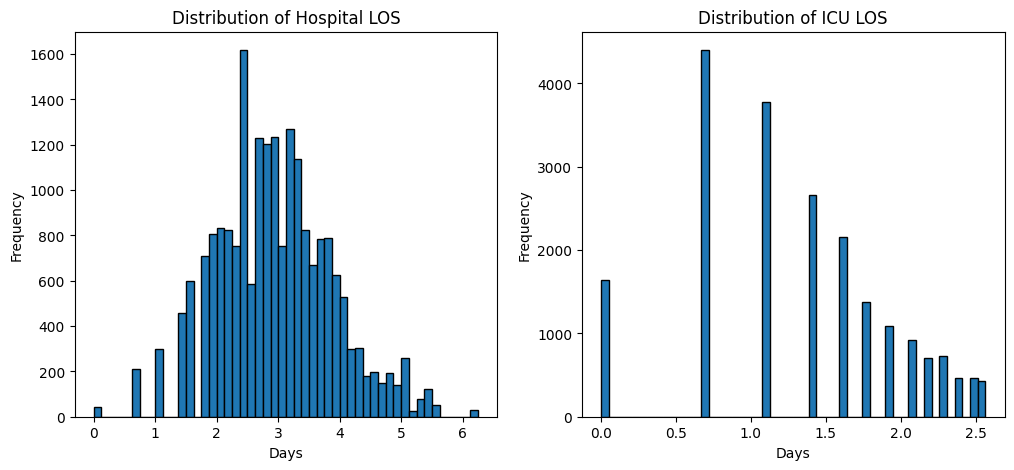

In [ ]:
# Distribution plot for Hospital LOS and ICU LOS
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(targets['hospital_los'], bins=50, edgecolor='black')
plt.title('Distribution of Hospital LOS')
plt.xlabel('Days')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(targets['icu_los'], bins=50, edgecolor='black')
plt.title('Distribution of ICU LOS')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Scale the regression targets
scaler_hospital_los = StandardScaler()
y_hospital_los_train_val_scaled = scaler_hospital_los.fit_transform(y_hospital_los_train_val.numpy())
y_hospital_los_test_scaled = scaler_hospital_los.transform(y_hospital_los_test.numpy())
y_hospital_los_train_val_scaled_tensor = torch.tensor(y_hospital_los_train_val_scaled, dtype=torch.float32).view(-1, 1)
y_hospital_los_test_scaled_tensor = torch.tensor(y_hospital_los_test_scaled, dtype=torch.float32).view(-1, 1)

scaler_icu_los = StandardScaler()
y_icu_los_train_val_scaled = scaler_icu_los.fit_transform(y_icu_los_train_val.numpy())
y_icu_los_test_scaled = scaler_icu_los.transform(y_icu_los_test.numpy())
y_icu_los_train_val_scaled_tensor = torch.tensor(y_icu_los_train_val_scaled, dtype=torch.float32).view(-1, 1)
y_icu_los_test_scaled_tensor = torch.tensor(y_icu_los_test_scaled, dtype=torch.float32).view(-1, 1)


In [ ]:
# Create Dataset and DataLoader
class PneumoniaDataset(Dataset):
    def __init__(self, features, mortality, hospital_los, icu_los, sepsis, respiratory, aki, clinical_deterioration, antibiotic_response, myocardial_infarction, recovery):
        self.features = features
        self.mortality = mortality
        self.hospital_los = hospital_los
        self.icu_los = icu_los
        self.sepsis = sepsis
        self.respiratory = respiratory
        self.aki = aki
        self.clinical_deterioration = clinical_deterioration
        self.antibiotic_response = antibiotic_response
        self.myocardial_infarction = myocardial_infarction
        self.recovery = recovery

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.mortality[idx], self.hospital_los[idx], self.icu_los[idx], self.sepsis[idx], self.respiratory[idx], self.aki[idx], self.clinical_deterioration[idx], self.antibiotic_response[idx], self.myocardial_infarction[idx], self.recovery[idx]

In [ ]:
# Recreate DataLoaders with scaled targets
train_val_dataset = PneumoniaDataset(X_train_val, y_mortality_train_val, y_hospital_los_train_val_scaled_tensor, y_icu_los_train_val_scaled_tensor, y_sepsis_train_val, y_respiratory_train_val, y_aki_train_val, y_clinical_deterioration_train_val, y_antibiotic_response_train_val, y_myocardial_infarction_train_val,  y_recovery_train_val)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_dataset_eval = PneumoniaDataset(X_test, y_mortality_test, y_hospital_los_test_scaled_tensor, y_icu_los_test_scaled_tensor, y_sepsis_test, y_respiratory_test, y_aki_test, y_clinical_deterioration_test, y_antibiotic_response_test, y_myocardial_infarction_test, y_recovery_test)
test_loader_eval = DataLoader(test_dataset_eval, batch_size=32)

In [ ]:
# Print the statsical info of the scaled X_train
print(pd.Series(X_train_val.flatten()).describe())

count    532832.000000
mean          0.000277
std           0.980802
min         -11.986533
25%          -0.473077
50%          -0.027279
75%           0.256465
max         101.997704
dtype: float64


In [ ]:
# Model Architecture
class MultiTargetModel(nn.Module):
        def __init__(self, input_size, hidden_size1=128, hidden_size2=64, dropout_rate=0.3):
            super(MultiTargetModel, self).__init__()
            self.shared_layers = nn.Sequential(
                nn.Linear(input_size, hidden_size1),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size1),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_size1, hidden_size2),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size2),
                nn.Dropout(dropout_rate)
            )
            self.mortality_output = nn.Linear(hidden_size2, 1)
            self.hospital_los_output = nn.Linear(hidden_size2, 1)
            self.icu_los_output = nn.Linear(hidden_size2, 1)
            self.respiratory_output = nn.Linear(hidden_size2, 1)
            self.sepsis_output = nn.Linear(hidden_size2, 1)
            self.aki_output = nn.Linear(hidden_size2, 1)
            self.clinical_deterioration_output = nn.Linear(hidden_size2, 1)
            self.antibiotic_response_output = nn.Linear(hidden_size2, 1)
            self.myocardial_infarction_output = nn.Linear(hidden_size2, 1)
            self.recovery_output = nn.Linear(hidden_size2, 1)

        def forward(self, x):
            shared = self.shared_layers(x)
            mortality = self.mortality_output(shared)
            hospital_los = self.hospital_los_output(shared)
            icu_los = self.icu_los_output(shared)
            sepsis = self.sepsis_output(shared)
            respiratory = self.respiratory_output(shared)
            aki = self.aki_output(shared)
            clinical_deterioration = self.clinical_deterioration_output(shared)
            antibiotic_response = self.antibiotic_response_output(shared)
            myocardial_infarction = self.myocardial_infarction_output(shared)
            recovery = self.recovery_output(shared)
            return mortality, hospital_los, icu_los, sepsis, respiratory, aki, clinical_deterioration, antibiotic_response, myocardial_infarction, recovery


In [ ]:
 # Weighted Loss Functions for Class Imbalance
def calculate_class_weights(targets):
        unique_classes, counts = np.unique(targets, return_counts=True)
        weights = len(targets) / (len(unique_classes) * counts)
        return torch.tensor(weights, dtype=torch.float32)

mortality_weights = calculate_class_weights(y_mortality_train_val.numpy().flatten())
mortality_weight = mortality_weights[1] if len(mortality_weights) > 1 else torch.tensor(1.0)
mortality_loss_fn_weighted = nn.BCEWithLogitsLoss(pos_weight=mortality_weight)

myocardial_infarction_weights = calculate_class_weights(y_myocardial_infarction_train_val.numpy().flatten())
myocardial_infarction_weight = myocardial_infarction_weights[1] if len(myocardial_infarction_weights) > 1 else torch.tensor(1.0)
myocardial_infarction_loss_fn_weighted = nn.BCEWithLogitsLoss(pos_weight=myocardial_infarction_weight)


In [ ]:
# Instantiate the model, loss functions, and optimizer
input_size = X_train_val.shape[1]

model=MultiTargetModel(input_size)

mortality_loss_fn = nn.BCEWithLogitsLoss()
los_loss_fn = nn.MSELoss()
sepsis_loss_fn = nn.BCEWithLogitsLoss()
respiratory_loss_fn = nn.BCEWithLogitsLoss()
aki_loss_fn = nn.BCEWithLogitsLoss()
clinical_deterioration_loss_fn = nn.BCEWithLogitsLoss()
antibiotic_response_loss_fn = nn.BCEWithLogitsLoss()
myocardial_infarction_loss_fn = nn.BCEWithLogitsLoss()
recovery_loss_fn = nn.BCEWithLogitsLoss()

# Hyperparameter Tuning
optimizer = optim.Adam(model.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [ ]:
# Training loop with validation
epochs = 100
for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for features, mortality, hospital_los, icu_los, sepsis, respiratory, aki, clinical_deterioration, antibiotic_response, myocardial_infarction, recovery in train_loader:
            optimizer.zero_grad()
            mortality_pred, hospital_los_pred, icu_los_pred, sepsis_pred, respiratory_pred, aki_pred, clinical_deterioration_pred, antibiotic_response_pred, myocardial_infarction_pred, recovery_pred = model(features)

            mortality_loss = mortality_loss_fn_weighted(mortality_pred, mortality.float())
            respiratory_loss = respiratory_loss_fn(respiratory_pred, respiratory.float())
            sepsis_loss = sepsis_loss_fn(sepsis_pred, sepsis.float())
            aki_loss = aki_loss_fn(aki_pred, aki.float())
            clinical_deterioration_loss = clinical_deterioration_loss_fn(clinical_deterioration_pred, clinical_deterioration.float())
            antibiotic_response_loss = antibiotic_response_loss_fn(antibiotic_response_pred, antibiotic_response.float())
            myocardial_infarction_loss = myocardial_infarction_loss_fn_weighted(myocardial_infarction_pred, myocardial_infarction.float())
            recovery_loss = recovery_loss_fn(recovery_pred, recovery.float())

            hospital_los_loss = los_loss_fn(hospital_los_pred, hospital_los.float())
            icu_los_loss = los_loss_fn(icu_los_pred, icu_los.float())

            loss = mortality_loss + hospital_los_loss + icu_los_loss + sepsis_loss + respiratory_loss + aki_loss + clinical_deterioration_loss + antibiotic_response_loss + myocardial_infarction_loss + recovery_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * features.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}', end=" ")

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features_val, mortality_val, hospital_los_val, icu_los_val, sepsis_val, respiratory_val, aki_val, clinical_deterioration_val, antibiotic_response_val, myocardial_infarction_val, recovery_val in val_loader:
                mortality_pred_val, hospital_los_pred_val, icu_los_pred_val, sepsis_pred_val, respiratory_pred_val, aki_pred_val, clinical_deterioration_pred_val, antibiotic_response_pred_val, myocardial_infarction_pred_val, recovery_pred_val = model(features_val)
                mortality_loss_val = mortality_loss_fn_weighted(mortality_pred_val, mortality_val.float())
                respiratory_loss_val = respiratory_loss_fn(respiratory_pred_val, respiratory_val.float())
                sepsis_loss_val = sepsis_loss_fn(sepsis_pred_val, sepsis_val.float())
                aki_loss_val = aki_loss_fn(aki_pred_val, aki_val.float())
                clinical_deterioration_loss_val = clinical_deterioration_loss_fn(clinical_deterioration_pred_val, clinical_deterioration_val.float())
                antibiotic_response_loss_val = antibiotic_response_loss_fn(antibiotic_response_pred_val, antibiotic_response_val.float())
                myocardial_infarction_loss_val = myocardial_infarction_loss_fn_weighted(myocardial_infarction_pred_val, myocardial_infarction_val.float())
                recovery_loss_val = recovery_loss_fn(recovery_pred_val, recovery_val.float())
                hospital_los_loss_val = los_loss_fn(hospital_los_pred_val, hospital_los_val.float())
                icu_los_loss_val = los_loss_fn(icu_los_pred_val, icu_los_val.float())
                loss_val = mortality_loss_val + hospital_los_loss_val + icu_los_loss_val + sepsis_loss_val + respiratory_loss_val + aki_loss_val + clinical_deterioration_loss_val + antibiotic_response_loss_val + myocardial_infarction_loss_val + recovery_loss_val
                val_loss += loss_val.item() * features_val.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f}')
        scheduler.step(val_loss)


Epoch 1/100, Training Loss: 7.7289 Validation Loss: 6.6314
Epoch 2/100, Training Loss: 6.3615 Validation Loss: 5.5467
Epoch 3/100, Training Loss: 5.5608 Validation Loss: 5.0795
Epoch 4/100, Training Loss: 5.2981 Validation Loss: 4.9943
Epoch 5/100, Training Loss: 5.1905 Validation Loss: 4.8940
Epoch 6/100, Training Loss: 5.1202 Validation Loss: 4.8268
Epoch 7/100, Training Loss: 5.0711 Validation Loss: 4.7875
Epoch 8/100, Training Loss: 5.0341 Validation Loss: 4.7607
Epoch 9/100, Training Loss: 4.9960 Validation Loss: 4.7493
Epoch 10/100, Training Loss: 4.9615 Validation Loss: 4.7032
Epoch 11/100, Training Loss: 4.9320 Validation Loss: 4.6730
Epoch 12/100, Training Loss: 4.9196 Validation Loss: 4.6420
Epoch 13/100, Training Loss: 4.8891 Validation Loss: 4.6318
Epoch 14/100, Training Loss: 4.8548 Validation Loss: 4.6046
Epoch 15/100, Training Loss: 4.8510 Validation Loss: 4.5788
Epoch 16/100, Training Loss: 4.8249 Validation Loss: 4.5778
Epoch 17/100, Training Loss: 4.7949 Validation Lo

In [ ]:
 # Evaluate Performance on Individual Tasks on the Test Set
def evaluate_individual_tasks(model, test_loader, hospital_los_scaler, icu_los_scaler):
        model.eval()
        all_mortality_preds = []
        all_mortality_targets = []
        all_hospital_los_preds = []
        all_hospital_los_targets = []
        all_icu_los_preds = []
        all_icu_los_targets = []
        all_sepsis_preds = []
        all_sepsis_targets = []
        all_respiratory_preds = []
        all_respiratory_targets = []
        all_aki_preds = []
        all_aki_targets = []
        all_clinical_deterioration_preds = []
        all_clinical_deterioration_targets = []
        all_antibiotic_response_preds = []
        all_antibiotic_response_targets = []
        all_myocardial_infarction_preds = []
        all_myocardial_infarction_targets = []
        all_recovery_preds = []
        all_recovery_targets = []

        with torch.no_grad():
            for features, mortality, hospital_los, icu_los, sepsis, respiratory, aki, clinical_deterioration, antibiotic_response, myocardial_infarction, recovery in test_loader:
                mortality_pred, hospital_los_pred, icu_los_pred, sepsis_pred, respiratory_pred, aki_pred, clinical_deterioration_pred, antibiotic_response_pred, myocardial_infarction_pred, recovery_pred = model(features)

                all_mortality_preds.extend(torch.sigmoid(mortality_pred).cpu().numpy())
                all_mortality_targets.extend(mortality.cpu().numpy())
                all_hospital_los_preds.extend(hospital_los_pred.cpu().numpy())
                all_hospital_los_targets.extend(hospital_los.cpu().numpy())
                all_icu_los_preds.extend(icu_los_pred.cpu().numpy())
                all_icu_los_targets.extend(icu_los.cpu().numpy())
                all_sepsis_preds.extend(torch.sigmoid(sepsis_pred).cpu().numpy())
                all_sepsis_targets.extend(sepsis.cpu().numpy())
                all_respiratory_preds.extend(torch.sigmoid(respiratory_pred).cpu().numpy())
                all_respiratory_targets.extend(respiratory.cpu().numpy())
                all_aki_preds.extend(torch.sigmoid(aki_pred).cpu().numpy())
                all_aki_targets.extend(aki.cpu().numpy())
                all_clinical_deterioration_preds.extend(torch.sigmoid(clinical_deterioration_pred).cpu().numpy())
                all_clinical_deterioration_targets.extend(clinical_deterioration.cpu().numpy())
                all_antibiotic_response_preds.extend(torch.sigmoid(antibiotic_response_pred).cpu().numpy())
                all_antibiotic_response_targets.extend(antibiotic_response.cpu().numpy())
                all_myocardial_infarction_preds.extend(torch.sigmoid(myocardial_infarction_pred).cpu().numpy())
                all_myocardial_infarction_targets.extend(myocardial_infarction.cpu().numpy())
                all_recovery_preds.extend(torch.sigmoid(recovery_pred).cpu().numpy())
                all_recovery_targets.extend(recovery.cpu().numpy())

        print("\n Performance on Individual Tasks (Test Set)")

        # Mortality
        mortality_preds_binary = np.round(all_mortality_preds)
        print(f"Mortality - Accuracy: {accuracy_score(all_mortality_targets, mortality_preds_binary):.4f}")
        print(f"Mortality - AUC: {roc_auc_score(all_mortality_targets, all_mortality_preds):.4f}")
        print(f"Mortality - Precision: {precision_score(all_mortality_targets, mortality_preds_binary, zero_division=0):.4f}")
        print(f"Mortality - Recall: {recall_score(all_mortality_targets, mortality_preds_binary, zero_division=0):.4f}")
        print(f"Mortality - F1 Score: {f1_score(all_mortality_targets, mortality_preds_binary, zero_division=0):.4f}")

        # Hospital LOS (Inverse transform and evaluate)
        predicted_hospital_los = hospital_los_scaler.inverse_transform(np.array(all_hospital_los_preds).reshape(-1, 1))
        actual_hospital_los = hospital_los_scaler.inverse_transform(np.array(all_hospital_los_targets).reshape(-1, 1))
        print(f"\nHospital LOS - MAE: {mean_absolute_error(actual_hospital_los, predicted_hospital_los):.4f}")

        # ICU LOS (Inverse transform using expm1 and evaluate)
        predicted_icu_los_scaled = np.array(all_icu_los_preds).reshape(-1, 1)
        actual_icu_los_scaled = np.array(all_icu_los_targets).reshape(-1, 1)
        predicted_icu_los = np.expm1(icu_los_scaler.inverse_transform(predicted_icu_los_scaled))
        actual_icu_los = np.expm1(icu_los_scaler.inverse_transform(actual_icu_los_scaled))
        print(f"ICU LOS - MAE: {mean_absolute_error(actual_icu_los, predicted_icu_los):.4f}")

        # Sepsis
        sepsis_preds_binary = np.round(all_sepsis_preds)
        print(f"\nHigh Risk Sepsis Shock - Accuracy: {accuracy_score(all_sepsis_targets, sepsis_preds_binary):.4f}")
        print(f"High Risk Sepsis Shock - AUC: {roc_auc_score(all_sepsis_targets, all_sepsis_preds):.4f}")
        print(f"High Risk Sepsis Shock - Precision: {precision_score(all_sepsis_targets, sepsis_preds_binary):.4f}")
        print(f"High Risk Sepsis Shock - Recall: {recall_score(all_sepsis_targets, sepsis_preds_binary):.4f}")
        print(f"High Risk Sepsis Shock - F1 Score: {f1_score(all_sepsis_targets, sepsis_preds_binary):.4f}")

        # Respiratory Support
        respiratory_preds_binary = np.round(all_respiratory_preds)
        print(f"\nNeed Respiratory Support - Accuracy: {accuracy_score(all_respiratory_targets, respiratory_preds_binary):.4f}")
        print(f"Need Respiratory Support - AUC: {roc_auc_score(all_respiratory_targets, all_respiratory_preds):.4f}")
        print(f"Need Respiratory Support - Precision: {precision_score(all_respiratory_targets, respiratory_preds_binary):.4f}")
        print(f"Need Respiratory Support - Recall: {recall_score(all_respiratory_targets, respiratory_preds_binary):.4f}")
        print(f"Need Respiratory Support - F1 Score: {f1_score(all_respiratory_targets, respiratory_preds_binary):.4f}")

        # AKI
        aki_preds_binary = np.round(all_aki_preds)
        print(f"\nHigh Risk AKI - Accuracy: {accuracy_score(all_aki_targets, aki_preds_binary):.4f}")
        print(f"High Risk AKI - AUC: {roc_auc_score(all_aki_targets, all_aki_preds):.4f}")
        print(f"High Risk AKI - Precision: {precision_score(all_aki_targets, aki_preds_binary):.4f}")
        print(f"High Risk AKI - Recall: {recall_score(all_aki_targets, aki_preds_binary):.4f}")
        print(f"High Risk AKI - F1 Score: {f1_score(all_aki_targets, aki_preds_binary):.4f}")

        # Clinical Deterioration
        clinical_deterioration_preds_binary = np.round(all_clinical_deterioration_preds)
        print(f"\nHigh Risk Clinical Deterioration - Accuracy: {accuracy_score(all_clinical_deterioration_targets, clinical_deterioration_preds_binary):.4f}")
        print(f"High Risk Clinical Deterioration - AUC: {roc_auc_score(all_clinical_deterioration_targets, all_clinical_deterioration_preds):.4f}")
        print(f"High Risk Clinical Deterioration - Precision: {precision_score(all_clinical_deterioration_targets, clinical_deterioration_preds_binary):.4f}")
        print(f"High Risk Clinical Deterioration - Recall: {recall_score(all_clinical_deterioration_targets, clinical_deterioration_preds_binary):.4f}")
        print(f"High Risk Clinical Deterioration - F1 Score: {f1_score(all_clinical_deterioration_targets, clinical_deterioration_preds_binary):.4f}")

        # Antibiotic Response
        antibiotic_response_preds_binary = np.round(all_antibiotic_response_preds)
        print(f"\nLikely Response to Antibiotic - Accuracy: {accuracy_score(all_antibiotic_response_targets, antibiotic_response_preds_binary):.4f}")
        print(f"Likely Response to Antibiotic - AUC: {roc_auc_score(all_antibiotic_response_targets, all_antibiotic_response_preds):.4f}")
        print(f"Likely Response to Antibiotic - Precision: {precision_score(all_antibiotic_response_targets, antibiotic_response_preds_binary):.4f}")
        print(f"Likely Response to Antibiotic - Recall: {recall_score(all_antibiotic_response_targets, antibiotic_response_preds_binary):.4f}")
        print(f"Likely Response to Antibiotic - F1 Score: {f1_score(all_antibiotic_response_targets, antibiotic_response_preds_binary):.4f}")

        # Myocardial Infarction
        myocardial_infarction_preds_binary = np.round(all_myocardial_infarction_preds)
        print(f"\nMyocardial Infarction - Accuracy: {accuracy_score(all_myocardial_infarction_targets, myocardial_infarction_preds_binary):.4f}")
        print(f"Myocardial Infarction - AUC: {roc_auc_score(all_myocardial_infarction_targets, all_myocardial_infarction_preds):.4f}")
        print(f"Myocardial Infarction - Precision: {precision_score(all_myocardial_infarction_targets, myocardial_infarction_preds_binary, zero_division=0):.4f}")
        print(f"Myocardial Infarction - Recall: {recall_score(all_myocardial_infarction_targets, myocardial_infarction_preds_binary, zero_division=0):.4f}")
        print(f"Myocardial Infarction - F1 Score: {f1_score(all_myocardial_infarction_targets, myocardial_infarction_preds_binary, zero_division=0):.4f}")

        # Recovery
        recovery_preds_binary = np.round(all_recovery_preds)
        print(f"\nRecovery - Accuracy: {accuracy_score(all_recovery_targets, recovery_preds_binary):.4f}")
        print(f"Recovery - AUC: {roc_auc_score(all_recovery_targets, all_recovery_preds):.4f}")
        print(f"Recovery - Precision: {precision_score(all_recovery_targets, recovery_preds_binary):.4f}")
        print(f"Recovery - Recall: {recall_score(all_recovery_targets, recovery_preds_binary):.4f}")
        print(f"Recovery - F1 Score: {f1_score(all_recovery_targets, recovery_preds_binary):.4f}")

# Evaluate on the test set
evaluate_individual_tasks(model, test_loader_eval, scaler_hospital_los, scaler_icu_los)


 Performance on Individual Tasks (Test Set)
Mortality - Accuracy: 0.8309
Mortality - AUC: 0.8651
Mortality - Precision: 0.6178
Mortality - Recall: 0.6351
Mortality - F1 Score: 0.6263

Hospital LOS - MAE: 0.4662
ICU LOS - MAE: 2.0716

High Risk Sepsis Shock - Accuracy: 0.9219
High Risk Sepsis Shock - AUC: 0.8106
High Risk Sepsis Shock - Precision: 0.9225
High Risk Sepsis Shock - Recall: 0.9992
High Risk Sepsis Shock - F1 Score: 0.9593

Need Respiratory Support - Accuracy: 0.7406
Need Respiratory Support - AUC: 0.7596
Need Respiratory Support - Precision: 0.7449
Need Respiratory Support - Recall: 0.9492
Need Respiratory Support - F1 Score: 0.8348

High Risk AKI - Accuracy: 0.7692
High Risk AKI - AUC: 0.8428
High Risk AKI - Precision: 0.8015
High Risk AKI - Recall: 0.7000
High Risk AKI - F1 Score: 0.7473

High Risk Clinical Deterioration - Accuracy: 0.7874
High Risk Clinical Deterioration - AUC: 0.7478
High Risk Clinical Deterioration - Precision: 0.7955
High Risk Clinical Deterioration 

**Knowledge Graph**

In [ ]:
import networkx as nx
import pandas as pd

pneumonia_kg = nx.Graph()

patient_id_list = [18346448, 15749149]

# Format the patient id's for display
patient_ids_to_display = [f"patient_{pid}" for pid in patient_id_list]


# Add core entities
pneumonia_kg.add_node("Pneumonia")
pneumonia_kg.add_node("Mortality")
pneumonia_kg.add_node("Sepsis Shock")
pneumonia_kg.add_node("Respiratory Support")
pneumonia_kg.add_node("AKI")
pneumonia_kg.add_node("Clinical Deterioration")
pneumonia_kg.add_node("Antibiotic Response")
pneumonia_kg.add_node("Myocardial Infarction")
pneumonia_kg.add_node("Recovery")
pneumonia_kg.add_node("Male")
pneumonia_kg.add_node("Female")

# Iterate through the DataFrame
for index, row in df.iterrows():
  if row['subject_id'] in patient_id_list:
        patient_id = f"patient_{int(row['subject_id'])}"
        pneumonia_kg.add_node(patient_id)
        pneumonia_kg.add_edge(patient_id, "Pneumonia", relation="has_diagnosis")

        if row['gender'] == 0:
          pneumonia_kg.add_edge(patient_id, "Male", relation="has_gender")
        elif row['gender'] == 1:
          pneumonia_kg.add_edge(patient_id, "Female", relation="has_gender")

        if row['mortality'] == 1:
          pneumonia_kg.add_edge(patient_id, "Mortality", relation="has_outcome")
        else:
          pneumonia_kg.add_edge(patient_id, "Recovery", relation="has_outcome")

        if row['high_risk_sepsis_shock'] == 1:
          pneumonia_kg.add_edge(patient_id, "Sepsis Shock", relation="developed")

        if row['need_respiratory_support'] == 1:
          pneumonia_kg.add_edge(patient_id, "Respiratory Support", relation="required")

        if row['high_risk_aki'] == 1:
          pneumonia_kg.add_edge(patient_id, "AKI", relation="developed")

        if row['high_risk_clinical_deterioration'] == 1:
          pneumonia_kg.add_edge(patient_id, "Clinical Deterioration", relation="experienced")

        if row['likely_response_to_antibiotic'] == 1:
          pneumonia_kg.add_edge(patient_id, "Antibiotic Response", relation="showed")

        if row['myocardial_infarction'] == 1:
          pneumonia_kg.add_edge(patient_id, "Myocardial Infarction", relation="experienced")


        pneumonia_kg.nodes[patient_id]['hospital_los'] = row['hospital_los']
        pneumonia_kg.nodes[patient_id]['icu_los'] = row['icu_los']



Checking for patient ID: patient_18346448
Found patient node: patient_18346448
  Neighbor: Pneumonia
  Neighbor: Mortality
  Neighbor: Sepsis Shock
  Neighbor: Respiratory Support
  Neighbor: AKI
  Neighbor: Clinical Deterioration
  Neighbor: Antibiotic Response
Checking for patient ID: patient_15749149
Found patient node: patient_15749149
  Neighbor: Pneumonia
  Neighbor: Recovery
  Neighbor: Sepsis Shock
  Neighbor: Respiratory Support
  Neighbor: Clinical Deterioration
  Neighbor: Antibiotic Response
Nodes to draw: {'patient_18346448', 'Pneumonia', 'Respiratory Support', 'Mortality', 'Clinical Deterioration', 'Recovery', 'Sepsis Shock', 'patient_15749149', 'Antibiotic Response', 'AKI'}
Number of nodes in subgraph: 10
Number of edges in subgraph: 13


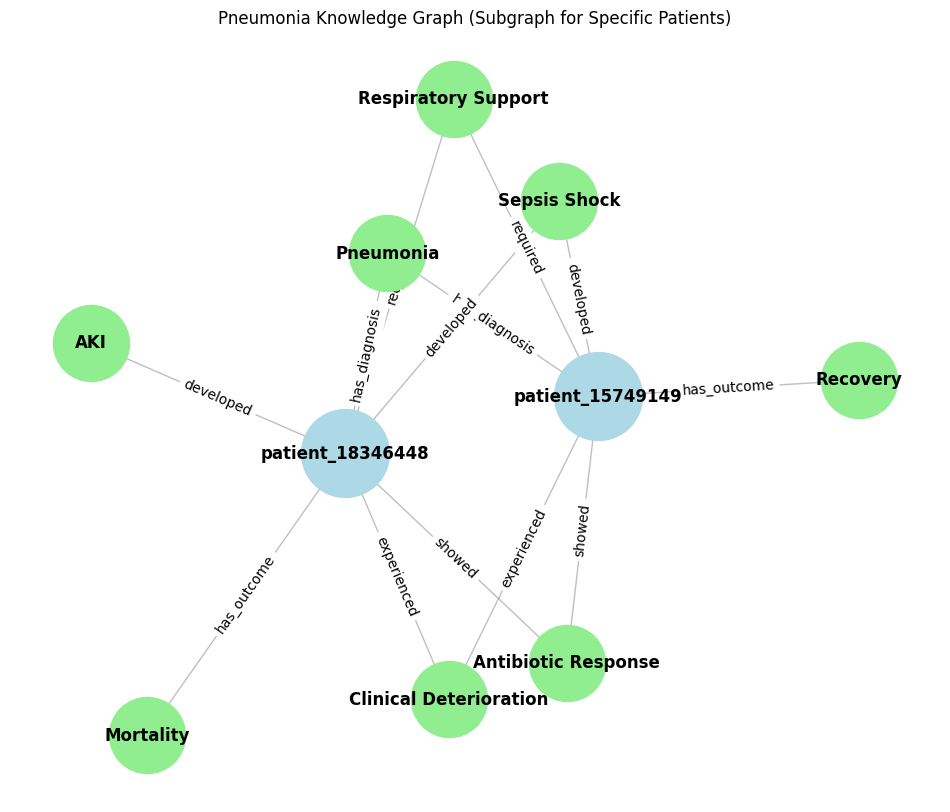

In [ ]:
# Display a Subgraph for Specific Patient
nodes_to_draw = set()
for patient_id in patient_ids_to_display:
    print(f"Checking for patient ID: {patient_id}")
    if patient_id in pneumonia_kg.nodes:
        print(f"Found patient node: {patient_id}")
        nodes_to_draw.add(patient_id)
        # Add neighbors of the patient node
        for neighbor in pneumonia_kg.neighbors(patient_id):
            print(f"  Neighbor: {neighbor}")
            nodes_to_draw.add(neighbor)
    else:
        print(f"Patient node not found: {patient_id}")

print(f"Nodes to draw: {nodes_to_draw}")

subgraph = pneumonia_kg.subgraph(nodes_to_draw)
print(f"Number of nodes in subgraph: {subgraph.number_of_nodes()}")
print(f"Number of edges in subgraph: {subgraph.number_of_edges()}")

plt.figure(figsize=(12, 10))

# Choose a layout for the subgraph
pos_subgraph = nx.spring_layout(subgraph, k=0.5, iterations=100)

patient_nodes = [node for node in nodes_to_draw if node.startswith("patient_")]
other_nodes = [node for node in nodes_to_draw if not node.startswith("patient_")]

# Draw the nodes of the subgraph
#nx.draw_networkx_nodes(subgraph, pos_subgraph, node_size=3000, node_color='lightgreen')
nx.draw_networkx_nodes(subgraph, pos_subgraph, nodelist=other_nodes, node_size=3000, node_color='lightgreen')
nx.draw_networkx_nodes(subgraph, pos_subgraph, nodelist=patient_nodes, node_size=4000, node_color='lightblue')

# Draw the edges of the subgraph
nx.draw_networkx_edges(subgraph, pos_subgraph, width=1, alpha=0.5, edge_color='gray')

# Get edge labels from the 'relation' attribute
edge_labels = nx.get_edge_attributes(subgraph, 'relation')

# Draw the edge labels
nx.draw_networkx_edge_labels(subgraph, pos_subgraph, edge_labels=edge_labels, font_size=10)

# Draw the labels of the subgraph
nx.draw_networkx_labels(subgraph, pos_subgraph, font_size=12, font_weight='bold')

# Add title
plt.title("Pneumonia Knowledge Graph (Subgraph for Specific Patients)")

# Show the plot
plt.axis("off")
plt.show()